# Main goal: 
- Hani is looking for the final list of genes which are drug induced significantly methylated, expressed and stabilized. 

    ○ Venn diagram 

    ○ UpsetR 

=> table of these genes with all logFCs, pvalues and screening scores. 


In [1]:
# cp -v radar/result.all.txt hl60_delta_mtyl_table.txt

In [281]:
import pandas as pd 
import numpy as np
# Teated vs. non-treated 
comparisons = [
    # HL-60 meRIP-seq - logFC
    'meRIP-seq/hl60_delta_mtyl_table.txt' ,
    # HL-60 Ribo-seq - lnTE
    'Ribo-seq/hl60_delta_te_table.txt' ,
    # HL-60 RNA-seq 
    # RNA experssion - log2FC
    'RNA-seq/hl60-exp/hl60_delta_exp_table.txt',
    # RNA stability  - logFC
    'RNA-seq/hl60-stbl/hl60_delta_stbl_table.txt',
    ## 5 other AML cell lines RNA-seq
    # RNA experssion - log2FC
    'RNA-seq/other-exp/kg1_delta_exp_table.txt', 'RNA-seq/other-exp/molm14_delta_exp_table.txt',
    'RNA-seq/other-exp/ociaml2_delta_exp_table.txt', 'RNA-seq/other-exp/ociaml3_delta_exp_table.txt',
    'RNA-seq/other-exp/thp1_delta_exp_table.txt',
    # RNA stability - logFC
    'RNA-seq/other-stbl/kg1_delta_stbl_table.txt', 'RNA-seq/other-stbl/molm14_delta_stbl_table.txt',
    'RNA-seq/other-stbl/ociaml2_delta_stbl_table.txt', 'RNA-seq/other-stbl/ociaml3_delta_stbl_table.txt',
    'RNA-seq/other-stbl/thp1_delta_stbl_table.txt'
]


# extract cell line name experiment name 
names = [c.split('/')[-1].replace('.txt','').replace('_table','') for c in comparisons]
tables = [pd.read_csv(x, sep = '\t') for x in comparisons]
cells = [names[i].split('_')[0] for i,x in enumerate(comparisons)]
experiments = [names[i].replace(cells[i]+'_', '') for i,x in enumerate(comparisons)]

# read data into Pandas Data.Frames 
Data = dict(((c,{}) for c in cells))
for i,x in enumerate(comparisons): 
    cel = cells[i]
    exp = experiments[i]
    # read data and write into dictionary 
    Data [cel][exp] = tables[i]

Data['hl60']['delta_te'] = Data['hl60']['delta_te'][['gene_id','gene_name','Estimate_treatmentDRUG','fdr_Pr...z.._treatmentDRUG']]
Data['hl60']['delta_mtyl'] = Data['hl60']['delta_mtyl'][['ensembl','name','logFC','p_value']]
Data['hl60']['delta_mtyl'].columns = ['gene_id','gene_name','logFC','pval']

Let's include CRISPR screening scores 

In [282]:
def make_score_df(screen, score, rep='ave_Rep1_Rep2'):
    '''
    Make dataframe for given score from CRISPR screening Excel file 
    '''

    score_cols = [i for i,c in enumerate(screen.columns) if score in c]
    # extract screen informations from Excel file 
    screen_info = list(zip(
        score_cols,
        screen.iloc[0, score_cols].tolist(), 
        screen.iloc[1, score_cols].tolist(), 
        screen.columns[score_cols].tolist() 
    ))
    
    # select columns for given score
    cols = [c[0] for c in screen_info if c[1] == rep]
    # remove top 3 rows 
    df = screen.iloc[3:,cols]
    # set DataFrame column names from row 1
    df.columns = screen.iloc[1,cols].tolist()
    # select rows with ENST prefix 
    df = df.iloc[[i for i,g in enumerate(df.transcripts) if 'ENST' in str(g)],:].reset_index(drop=True)
    # add gene_name column
    gene_names = screen.iloc[3:,0]
    df.insert (0, "gene_name", [g for g,t in zip(gene_names,df.transcripts) if 'ENST' in str(t)])
    # only keep one transcript name
    df.transcripts = [g.split(',')[0] for g in df.transcripts]    
    # rename phenotype score column to the score name
    df.columns = [score + ' score' if x=='average phenotype of strongest 3' else x for x in df.columns]
    return df

In [283]:
screen = pd.read_excel('screen/CRISPRi_HL60_DAC_genetable_collapsed.xlsx')

Data['hl60']['rho'] = make_score_df(screen, 'rho')
Data['hl60']['gamma'] = make_score_df(screen, 'gamma')

# Intersectional genes 
Find top genes across all cell lines and high throughput experiments:

In [325]:
Top = {}

In [326]:
def find_top(
    df,
    value, value_thr, stat, stat_thr,
    n_line=None, drop_dup=False):
    
    # Select rows (genes) which has value >= value_thr & stat < stat_thr 
    if n_line==None:
        up = df.iloc[
            [i for i,l in enumerate(
                np.array([
                    np.array(df.loc[:,value] >= value_thr),
                    np.array(df.loc[:,stat] < stat_thr)]).all(axis=0)) if l == 1]
                ,:] 
        dn = df.iloc[
            [i for i,l in enumerate(
                np.array([
                    np.array(df.loc[:,value] <= -1*(value_thr)),
                    np.array(df.loc[:,stat] < stat_thr)]).all(axis=0)) if l == 1]
                ,:] 
        
    # found in more than n_line cell lines 
    else:
        up = df.iloc[
            [i for i,l in enumerate(
                np.array([
                    np.array(df.loc[:,value] >= value_thr).sum(axis=1) >= n_line,
                    np.array(df.loc[:,stat] < stat_thr).sum(axis=1) >= n_line]
                ).all(axis=0)) if l == 1]
                ,:]
        dn = df.iloc[
            [i for i,l in enumerate(
                np.array([
                    np.array(df.loc[:,value] <= -1*(value_thr)).sum(axis=1) >= n_line,
                    np.array(df.loc[:,stat] < stat_thr).sum(axis=1) >= n_line,]
                ).all(axis=0)) if l == 1]
                ,:] 
        
    if drop_dup==True:
        up = up.sort_values(stat).drop_duplicates(subset='gene_id', keep="last")
        dn = dn.sort_values(stat).drop_duplicates(subset='gene_id', keep="last")
    
    print ('up: ', up.shape)
    print ('down:', dn.shape)

    return up, dn


## Translational efficiency

In [327]:
Top['TE'] = {}

te_thr=0.5 # Estimate_treatmentDRUG
fdr_thr=0.10 # fdr_Pr...z.._treatmentDRUG

Top['TE']['threshold'] = [['te_thr',te_thr],['fdr_thr',fdr_thr]]

Top['TE']['up'], Top['TE']['down'] = find_top(
    Data['hl60']['delta_te'], 'Estimate_treatmentDRUG', te_thr, 'fdr_Pr...z.._treatmentDRUG', fdr_thr
)

up:  (27, 4)
down: (7, 4)


## $\Delta$RNA methylation

In [328]:
fc_thr = 4
pv_thr = 0.0001

Top['Mtyl'] = {}

Top['Mtyl']['threshold'] = [['fc_thr',fc_thr],['pv_thr',pv_thr]]

Top['Mtyl']['up'], Top['Mtyl']['down'] = find_top(Data['hl60']['delta_mtyl'], 'logFC', 4, 'pval', 0.0001, drop_dup=True)

up:  (449, 4)
down: (49, 4)


## $\Delta$RNA expression 

In [46]:
E1 = Data['hl60']['delta_exp']
E2 = Data['kg1']['delta_exp']
E3 = Data['molm14']['delta_exp']
E4 = Data['ociaml2']['delta_exp']
E5 = Data['ociaml3']['delta_exp']
E6 = Data['thp1']['delta_exp']

load R

In [47]:
%reload_ext rpy2.ipython

In [86]:
%%R 
library (tidyverse)

Merge expression results from all AML cell lines into one DataFrame:

In [49]:
%%R -i E1,E2,E3,E4,E5,E6 -o exp_df

exp_ids = E1[,'gene_id']
exp_names = E1[,'gene_name']

Exp = list(
    # hl60
    E1 %>% dplyr::select('gene_id','log2FC_120h','pval_120h') %>% 
            rename(hl60.log2FC=log2FC_120h,
                   hl60.pval=pval_120h), 
    # kg1
    E2 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>%
            rename(kg1.log2FC=log2FoldChange,
                   kg1.pval=pvalue),  
    # molm14
    E3 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>%
            rename(molm14.log2FC=log2FoldChange,
                   molm14.pval=pvalue), 
    # ociaml2
    E4 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>%
            rename(ociaml2.log2FC=log2FoldChange,
                   ociaml2.pval=pvalue), 
    # ociaml3    
    E5 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>% 
            rename(ociaml3.log2FC=log2FoldChange,
                   ociaml3.pval=pvalue), 
    # thp1
    E6 %>% dplyr::select('gene_id','log2FoldChange','pvalue') %>%
            rename(thp1.log2FC=log2FoldChange,
                   thp1.pval=pvalue) 
)

for (i in 1:6){
    Exp[[i]] = Exp[[i]] %>% data.frame %>% remove_rownames %>% column_to_rownames('gene_id')
    Exp[[i]] = Exp[[i]][exp_ids,]
    
}

exp_df <- bind_cols(Exp) %>% add_column(gene_name=exp_names, .before=1)

In [50]:
exp_df.to_csv('delta_expression.txt')

In [329]:
Top['Exp'] = {}
fc_thr = 0.5
pv_thr = 0.05
Top['Exp']['threshold'] = [['fc_thr',fc_thr],['pv_thr',pv_thr]]

Top['Exp']['up'], Top['Exp']['down'] = find_top(
    exp_df, 
    [c for c in exp_df.columns if 'log2FC' in c], fc_thr,
    [c for c in exp_df.columns if 'pval' in c], pv_thr,
    n_line=4
)

up:  (116, 13)
down: (7, 13)


## $\Delta$RNA stability

In [52]:
S1 = Data['hl60']['delta_stbl']
S2 = Data['kg1']['delta_stbl']
S3 = Data['molm14']['delta_stbl']
S4 = Data['ociaml2']['delta_stbl']
S5 = Data['ociaml3']['delta_stbl']
S6 = Data['thp1']['delta_stbl']

Merge stability results from all AML cell lines into one DataFrame:

In [53]:
%%R -i S1,S2,S3,S4,S5,S6 -o stbl_df

stbl_ids = S1[,'ensembl_id']
stbl_names = S1[,'gene_name']

Stbl = list(
    # hl60
    S1 %>% dplyr::select('ensembl_id','logFC_120h','P.Value_120h') %>% 
            rename(hl60.log2FC=logFC_120h,
                   hl60.pval=P.Value_120h), 
    # kg1
    S2 %>% dplyr::select('ensembl_id','logFC','P.Value') %>%
            rename(kg1.log2FC=logFC,
                   kg1.pval=P.Value),  
    # molm14
    S3 %>% dplyr::select('ensembl_id','logFC','P.Value') %>%
            rename(molm14.log2FC=logFC,
                   molm14.pval=P.Value), 
    # ociaml2
    S4 %>% dplyr::select('ensembl_id','logFC','P.Value') %>%
            rename(ociaml2.log2FC=logFC,
                   ociaml2.pval=P.Value), 
    # ociaml3    
    S5 %>% dplyr::select('ensembl_id','logFC','P.Value') %>% 
            rename(ociaml3.log2FC=logFC,
                   ociaml3.pval=P.Value), 
    # thp1
    S6 %>% dplyr::select('ensembl_id','logFC','P.Value') %>%
            rename(thp1.log2FC=logFC,
                   thp1.pval=P.Value) 
)

for (i in 1:6){
    Stbl[[i]] = Stbl[[i]] %>% data.frame %>% remove_rownames %>% column_to_rownames('ensembl_id')
    Stbl[[i]] = Stbl[[i]][stbl_ids,]
    
}

stbl_df <- bind_cols(Stbl) %>% add_column(gene_name=stbl_names, .before=1)

In [54]:
exp_df.to_csv('delta_stability.txt')

In [330]:
Top['Stbl'] = {}

fc_thr = 0.1
pv_thr = 0.05

Top['Stbl']['threshold'] = [['fc_thr',fc_thr],['pv_thr',pv_thr]]

Top['Stbl']['up'], Top['Stbl']['down'] = find_top(
    stbl_df, 
    [c for c in stbl_df.columns if 'log2FC' in c], fc_thr,
    [c for c in stbl_df.columns if 'pval' in c], pv_thr,
    n_line=4
)

up:  (8, 13)
down: (14, 13)


## $\Delta$ Phenotype 

In [331]:
Top['Rho'] = {}

sc_thr = 0.1
pv_thr = 0.05

Top['Rho']['threshold'] = [['sc_thr',sc_thr],['pv_thr',pv_thr]]
Top['Rho']['up'], Top['Rho']['down']  = find_top(Data['hl60']['rho'], 'rho score', sc_thr,'Mann-Whitney p-value', pv_thr)

up:  (26, 6)
down: (29, 6)


# UpSetR plots

Up regulated genes with drug:

In [347]:
Exp_up = Top['Exp']['up'].gene_name.tolist()
Stbl_up = Top['Stbl']['up'].gene_name.tolist()
TE_up = Top['TE']['up'].gene_name.tolist()
Rho_up = Top['Rho']['up'].index.tolist()
Hyper_m6A = Top['Mtyl']['up'].gene_name.tolist()

Exp_down = Top['Exp']['down'].gene_name.tolist()
Stbl_down = Top['Stbl']['down'].gene_name.tolist()
TE_down = Top['TE']['down'].gene_name.tolist()
Rho_down = Top['Rho']['down'].index.tolist()
Hypo_m6A = Top['Mtyl']['down'].gene_name.tolist()

In [211]:
%reload_ext rpy2.ipython

In [212]:
%%R 
library(UpSetR)

Up regulated genes with drug:

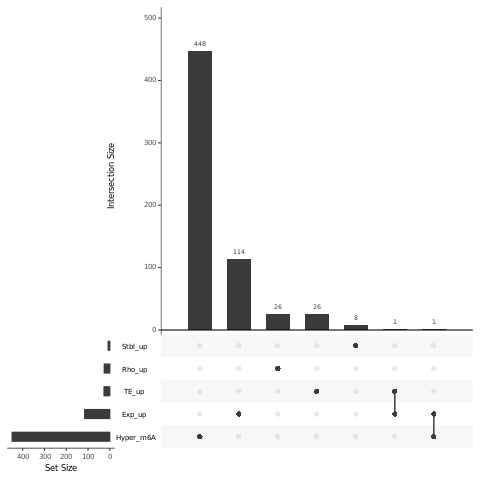

In [348]:
%%R -i Exp_up,Stbl_up,TE_up,Rho_up,Hyper_m6A
Vecs <- list(
    Rho_up=unlist(Rho_up), 
    TE_up=unlist(TE_up), Exp_up=unlist(Exp_up), 
    Stbl_up=unlist(Stbl_up), Hyper_m6A=unlist(Hyper_m6A)
)
intersection <- Reduce(intersect,Vecs)
upset(fromList(Vecs), order.by = "freq")

Down regulated genes with drug:

R[write to console]: geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



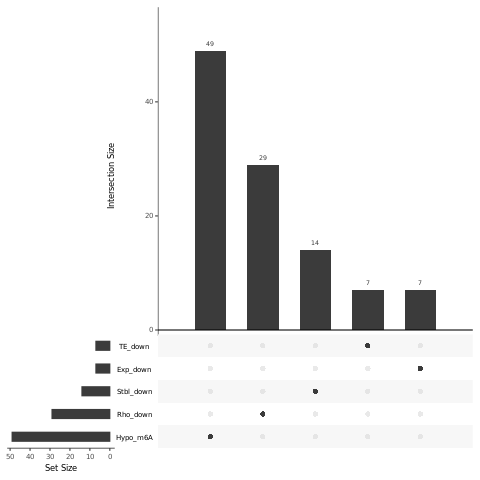

In [349]:
%%R -i Exp_down,Stbl_down,TE_down,Rho_down,Hypo_m6A
Vecs <- list(
    Rho_down=unlist(Rho_down), 
    TE_down=unlist(TE_down), Exp_down=unlist(Exp_down), 
    Stbl_down=unlist(Stbl_down), Hypo_m6A=unlist(Hypo_m6A)
)
intersection <- Reduce(intersect,Vecs)
upset(fromList(Vecs), order.by = "freq")

# Venn diagram 

- https://python-graph-gallery.com/172-custom-venn-diagram/
- https://stackoverflow.com/questions/19841535/python-matplotlib-venn-diagram
- https://towardsdatascience.com/how-to-create-and-customize-venn-diagrams-in-python-263555527305

In [553]:
# Import the library
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from matplotlib_venn import venn3

def venn_diagram(a, b, c, labels=['A', 'B', 'C']):
    
    a = list(set(a))
    b = list(set(b))
    c = list(set(c))
    
    only_a = len( [x for x in a if x not in b+c] )
    only_b = len( [x for x in b if x not in a+c] )
    only_c = len( [x for x in c if x not in a+b] )

    a_b = len(np.intersect1d(a, b))
    a_c = len(np.intersect1d(a, c))
    b_c = len(np.intersect1d(b, c))
    
    a_b_c = len([ x for x in a if (x in b) and (x in c)])
    
    venn3(subsets=(only_a, only_b, a_b, only_c, a_c, b_c, a_b_c), set_labels=labels)    
    
def iter_venn(datasets, names):
    # unique permutations on the number of given datasets 
    iterations = list(combinations(list(range(len(datasets))), 3))
    # draw unique venn_diagrams
    for i,iteration in enumerate(iterations):
        p = plt.figure(i)
        a,b,c=[datasets[n] for n in iteration]
        venn_diagram(a,b,c,labels=[names[n] for n in iteration]
        )
        p.show()    

### Intersection of all genes across different datasets

In [545]:
datasets= [
    list(set(Data['hl60']['delta_mtyl'].gene_name.tolist())),
    list(set(Data['hl60']['delta_te'].gene_name.tolist())),
    list(set(Data['hl60']['rho'].gene_name.tolist())),
    list(set(stbl_df.gene_name.tolist())),
    list(set(exp_df.gene_name.tolist()))
]

names = ['delta_mtyl', 'delta_te','rho score', 'delta_stbl','delta_exp']

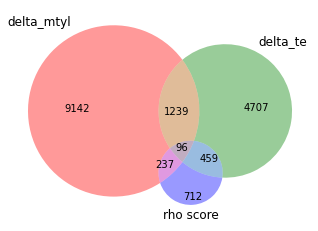

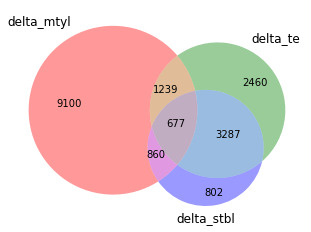

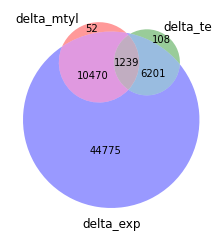

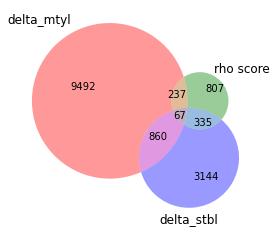

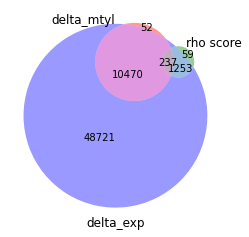

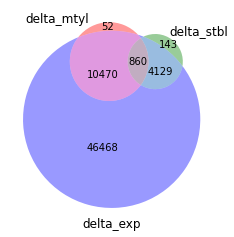

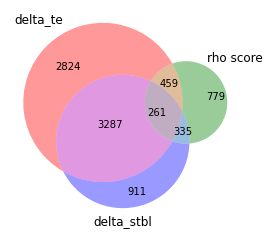

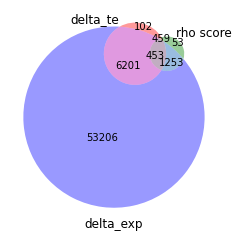

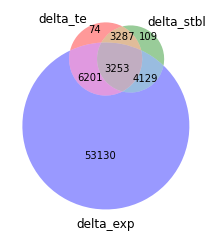

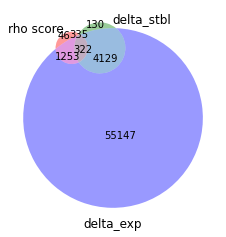

In [556]:
iter_venn(datasets, names)

### Up-regulated genes 

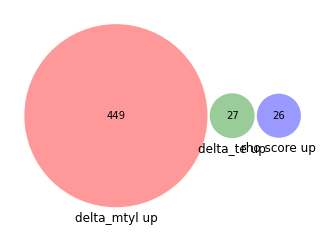

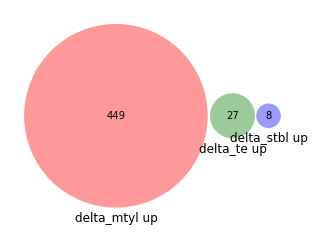

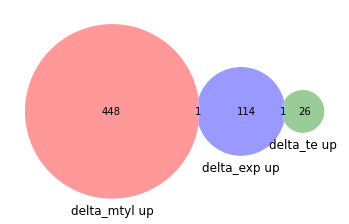

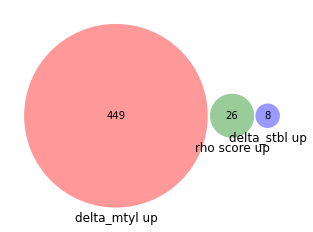

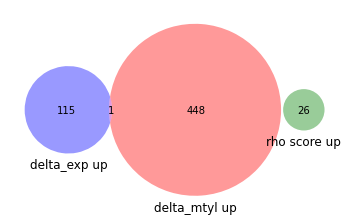

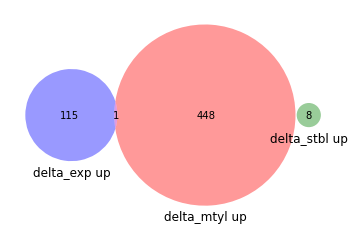

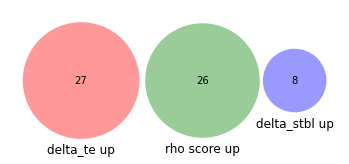

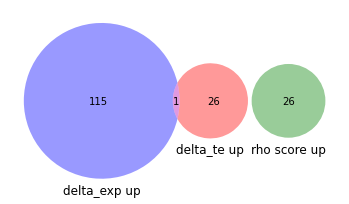

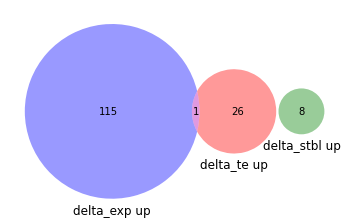

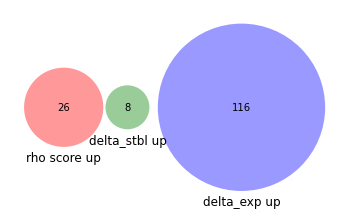

In [557]:
iter_venn(
    [Hyper_m6A,TE_up,Rho_up,Stbl_up,Exp_up], 
    [n + ' up' for n in names]
)

### Down regulated genes 

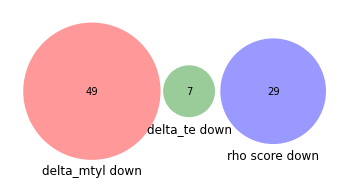

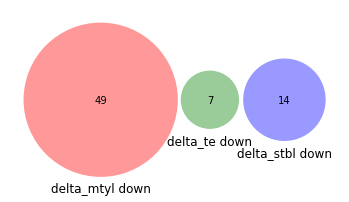

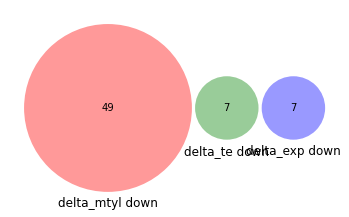

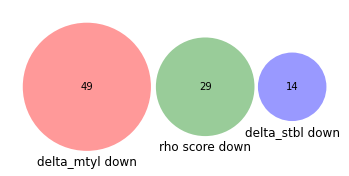

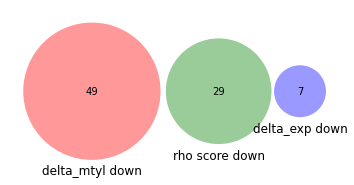

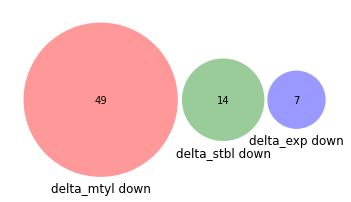

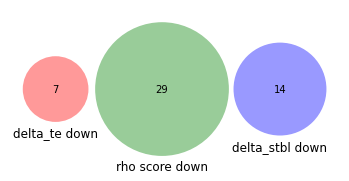

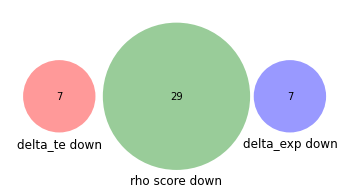

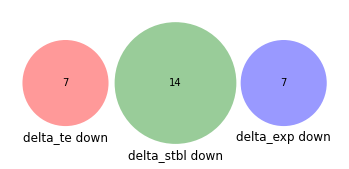

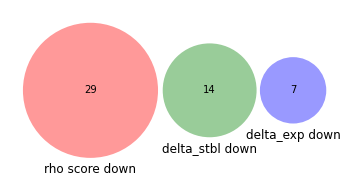

In [558]:
# 
iter_venn(
    [Hypo_m6A,TE_down,Rho_down,Stbl_down,Exp_down],
    [n + ' down' for n in names]
)

# Final merged table

In [358]:
# [Data['hl60'][d] for d in ['delta_mtyl', 'delta_te', 'rho', 'gamma']]

In [559]:
# uniq_genes = set(
# #     set(Data['hl60']['delta_te'].gene_name.tolist()) |
# #     set(Data['hl60']['delta_mtyl'].gene_name.tolist()) |
# #     set(Data['hl60']['rho'].gene_name.tolist()) |
# #     set(stbl_df.gene_name.tolist()) |
# #     set(exp_df.gene_name.tolist()) |
# )

# len(uniq_genes)

I'm not sure which subset of genes are related to our purpose.

In [38]:
%%R 
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/deseq2/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] UpSetR_1.4.0    forcats_0.5.0   stringr_1.4.0   dplyr_1.0.2    
 [5] purrr_0.3.4     readr_1.4.0     tidyr_1.1.2     tibble_3.0.4   
 [9] ggplot2_3.3.2   tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.4.6     plyr_1.8.6       pillar_1.4.6     compiler_4.0.

In [40]:
# https://stackoverflow.com/questions/2617600/importing-data-from-a-json-file-into-r